In [1]:
# ================================================================================================
# MASK R-CNN BIRD DETECTION PROJECT
# ================================================================================================
# Project: Fine-tuning Mask R-CNN for Bird Detection using CUB-200-2011 Dataset
# Author: Aris Marcel Luis
# Date: June 2025
# Description: This notebook implements Mask R-CNN for bird detection and segmentation
# ================================================================================================

# Core PyTorch and TorchVision imports
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision.transforms as T
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader

# Image processing and visualization
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# System utilities
import os
from tqdm import tqdm

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"TorchVision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ All libraries imported successfully!
PyTorch version: 2.5.1+cu121
TorchVision version: 0.20.1+cu121
CUDA available: True


In [2]:
# ================================================================================================
# 1. DEVICE SETUP AND MODEL INITIALIZATION
# ================================================================================================

def setup_device():
    """
    Setup and configure the computation device (GPU/CPU)
    
    Returns:
        torch.device: The selected device for computation
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if torch.cuda.is_available():
        print(f"🚀 Using GPU: {torch.cuda.get_device_name(0)}")
        print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        print(f"   CUDA Version: {torch.version.cuda}")
    else:
        print("⚠️  GPU not available, using CPU")
        print("   Note: Training will be significantly slower on CPU")
    
    return device

def load_pretrained_maskrcnn(device):
    """
    Load pre-trained Mask R-CNN model with COCO weights
    
    Args:
        device (torch.device): Device to load the model on
        
    Returns:
        torch.nn.Module: Pre-trained Mask R-CNN model
    """
    print("\n📥 Loading pre-trained Mask R-CNN model...")
    
    # Load pre-trained weights from COCO dataset
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)
    
    # Move model to specified device
    model.to(device)
    
    # Set model to evaluation mode (will be changed to training mode later)
    model.eval()
    
    print("✅ Mask R-CNN model loaded successfully!")
    print(f"   Architecture: ResNet-50 FPN")
    print(f"   Pre-trained on: COCO Dataset")
    print(f"   Device: {device}")
    
    return model

# Execute setup
device = setup_device()
model = load_pretrained_maskrcnn(device)

🚀 Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   GPU Memory: 8.0 GB
   CUDA Version: 12.1

📥 Loading pre-trained Mask R-CNN model...
✅ Mask R-CNN model loaded successfully!
   Architecture: ResNet-50 FPN
   Pre-trained on: COCO Dataset
   Device: cuda
✅ Mask R-CNN model loaded successfully!
   Architecture: ResNet-50 FPN
   Pre-trained on: COCO Dataset
   Device: cuda


In [3]:
# ================================================================================================
# 2. MODEL CUSTOMIZATION FOR BIRD DETECTION
# ================================================================================================

def customize_maskrcnn_for_birds(model, num_classes, device):
    """
    Customize Mask R-CNN model for bird detection by modifying the classification and mask heads
    
    Args:
        model (torch.nn.Module): Pre-trained Mask R-CNN model
        num_classes (int): Number of classes (background + bird = 2)
        device (torch.device): Device to move the model to
        
    Returns:
        torch.nn.Module: Customized model for bird detection
    """
    print(f"\n🔧 Customizing model for {num_classes} classes (background + bird)...")
    
    # Move model to CPU temporarily for head modification (recommended practice)
    model.to("cpu")
    
    # 1. Replace Box Predictor (Classification and Bounding Box Regression)
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features_box, num_classes
    )
    print(f"   ✅ Box predictor updated: {in_features_box} -> {num_classes} classes")
    
    # 2. Replace Mask Predictor (Instance Segmentation)
    in_features_mask = model.roi_heads.mask_predictor.mask_fcn_logits.in_channels
    hidden_layer = model.roi_heads.mask_predictor.mask_fcn_logits.out_channels
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )
    print(f"   ✅ Mask predictor updated: {in_features_mask} -> {hidden_layer} -> {num_classes} classes")
    
    # Move model back to the specified device
    model.to(device)
    
    print(f"🎯 Model successfully customized for bird detection!")
    print(f"   Device: {device}")
    print(f"   Ready for fine-tuning")
    
    return model

# Configuration
NUM_CLASSES_BIRDS = 2  # 1 for 'bird' + 1 for 'background'

# Customize the model
model = customize_maskrcnn_for_birds(model, NUM_CLASSES_BIRDS, device)

# Display model summary
print(f"\n📊 Model Summary:")
print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"   Model size: ~{sum(p.numel() * p.element_size() for p in model.parameters()) / 1024**2:.1f} MB")


🔧 Customizing model for 2 classes (background + bird)...
   ✅ Box predictor updated: 1024 -> 2 classes
   ✅ Mask predictor updated: 256 -> 91 -> 2 classes
🎯 Model successfully customized for bird detection!
   Device: cuda
   Ready for fine-tuning

📊 Model Summary:
   Total parameters: 43,752,940
   Trainable parameters: 43,530,540
   Model size: ~166.9 MB
🎯 Model successfully customized for bird detection!
   Device: cuda
   Ready for fine-tuning

📊 Model Summary:
   Total parameters: 43,752,940
   Trainable parameters: 43,530,540
   Model size: ~166.9 MB


In [4]:
def parse_bounding_boxes(boxes_file):
    """
    Parse bounding boxes from CUB dataset file
    
    Args:
        boxes_file (str): Path to bounding_boxes.txt file
        
    Returns:
        dict: Mapping of image_id to [x, y, width, height]
    """
    box_data = {}
    try:
        with open(boxes_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_id = int(parts[0])
                x, y, w, h = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
                box_data[image_id] = [x, y, w, h]
        print(f"   ✅ Loaded {len(box_data)} bounding boxes")
    except Exception as e:
        print(f"   ❌ Error loading bounding boxes: {e}")
        raise
    return box_data

def parse_image_names(images_file):
    """
    Parse image names from CUB dataset file
    
    Args:
        images_file (str): Path to images.txt file
        
    Returns:
        dict: Mapping of image_id to image filename
    """
    image_names = {}
    try:
        with open(images_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                image_id = int(parts[0])
                image_name = parts[1]
                image_names[image_id] = image_name
        print(f"   ✅ Loaded {len(image_names)} image names")
    except Exception as e:
        print(f"   ❌ Error loading image names: {e}")
        raise
    return image_names

class BirdMaskRCNNDataset(Dataset):
    """
    Custom Dataset class for CUB-200-2011 bird dataset with segmentation masks
    
    This dataset combines:
    - Original CUB images
    - Bounding box annotations
    - Custom segmentation masks
    """
    
    def __init__(self, root_dir, segmentations_dir, transforms=None):
        """
        Initialize the dataset
        
        Args:
            root_dir (str): Path to CUB_200_2011 root directory
            segmentations_dir (str): Path to segmentation masks directory
            transforms (callable, optional): Transformations to apply
        """
        self.root_dir = root_dir
        self.segmentations_dir = segmentations_dir
        self.transforms = transforms
        
        print(f"🗂️  Initializing BirdMaskRCNNDataset...")
        print(f"   Root directory: {root_dir}")
        print(f"   Segmentations directory: {segmentations_dir}")
        
        # Define file paths
        self.image_dir = os.path.join(root_dir, 'CUB_200_2011', 'images')
        self.bounding_boxes_file = os.path.join(root_dir, 'CUB_200_2011', 'bounding_boxes.txt')
        self.images_file = os.path.join(root_dir, 'CUB_200_2011', 'images.txt')
        
        # Validate paths
        self._validate_paths()
        
        # Load annotations
        print("📋 Loading annotations...")
        self.image_names_map = parse_image_names(self.images_file)
        self.bounding_box_map = parse_bounding_boxes(self.bounding_boxes_file)
        
        # Get valid image IDs (images that have both bbox and exist)
        self.image_ids = self._get_valid_image_ids()
        
        print(f"✅ Dataset initialized successfully!")
        print(f"   Total valid images: {len(self.image_ids)}")
    
    def _validate_paths(self):
        """Validate that all required paths exist"""
        required_paths = [
            self.image_dir,
            self.bounding_boxes_file,
            self.images_file,
            self.segmentations_dir
        ]
        
        for path in required_paths:
            if not os.path.exists(path):
                raise FileNotFoundError(f"Required path not found: {path}")
    
    def _get_valid_image_ids(self):
        """Get list of valid image IDs that have all required data"""
        valid_ids = []
        
        for image_id in self.bounding_box_map.keys():
            if image_id in self.image_names_map:
                # Check if image file exists
                image_path = os.path.join(self.image_dir, self.image_names_map[image_id])
                
                # Check if corresponding mask exists
                mask_filename = self.image_names_map[image_id].replace('.jpg', '.png')
                mask_path = os.path.join(self.segmentations_dir, mask_filename)
                
                if os.path.exists(image_path) and os.path.exists(mask_path):
                    valid_ids.append(image_id)
        
        return sorted(valid_ids)
    
    def __len__(self):
        """Return the total number of samples in the dataset"""
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset
        
        Args:
            idx (int): Index of the sample
            
        Returns:
            tuple: (image_tensor, target_dict)
        """
        try:
            image_id = self.image_ids[idx]
            image_filename_relative = self.image_names_map[image_id]
            image_path = os.path.join(self.image_dir, image_filename_relative)
            
            # Load corresponding mask
            mask_filename_relative = image_filename_relative.replace('.jpg', '.png')
            mask_path = os.path.join(self.segmentations_dir, mask_filename_relative)
            
            # Load image and convert to RGB
            img = Image.open(image_path).convert("RGB")
            
            # Load mask and convert to grayscale
            mask = Image.open(mask_path).convert("L")
            mask = np.array(mask)
            
            # Process mask to get individual object instances
            obj_ids = np.unique(mask)
            obj_ids = obj_ids[1:]  # Remove background (0)
            
            # Create binary masks for each object
            masks = mask == obj_ids[:, None, None]
            
            num_objs = len(obj_ids)
            boxes = []
            labels_valid = []
            masks_valid = []
            
            # Extract bounding boxes and validate them
            for i in range(num_objs):
                pos = np.where(masks[i])
                if len(pos[0]) == 0:  # Skip empty masks
                    continue
                    
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                
                # Validate bounding box dimensions
                if xmax > xmin and ymax > ymin:
                    boxes.append([xmin, ymin, xmax, ymax])
                    labels_valid.append(1)  # Bird class
                    masks_valid.append(masks[i])
            
            # Handle case with no valid objects
            if not boxes:
                return self._create_dummy_target(img, image_id)
            
            # Convert to tensors
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels_valid, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks_valid), dtype=torch.uint8)
            
            # Calculate areas and iscrowd
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
            
            # Create target dictionary
            target = {
                "boxes": boxes,
                "labels": labels,
                "masks": masks,
                "image_id": torch.tensor([image_id]),
                "area": area,
                "iscrowd": iscrowd
            }
            
            # Convert image to tensor
            img = T.PILToTensor()(img)
            img = T.ConvertImageDtype(torch.float)(img)
            
            return img, target
            
        except Exception as e:
            print(f"⚠️  Error processing sample {idx}: {e}")
            # Return dummy data to prevent training interruption
            return self._create_dummy_target(Image.new('RGB', (224, 224)), 0)
    
    def _create_dummy_target(self, img, image_id):
        """Create dummy target for invalid samples"""
        if isinstance(img, Image.Image):
            img_array = np.array(img)
            h, w = img_array.shape[:2]
        else:
            h, w = img.shape[1], img.shape[2]
        
        dummy_target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.zeros((0,), dtype=torch.int64),
            "masks": torch.zeros((0, h, w), dtype=torch.uint8),
            "image_id": torch.tensor([image_id]),
            "area": torch.zeros((0,), dtype=torch.float32),
            "iscrowd": torch.zeros((0,), dtype=torch.int64)
        }
        
        if isinstance(img, Image.Image):
            img = T.PILToTensor()(img)
            img = T.ConvertImageDtype(torch.float)(img)
        
        return img, dummy_target

# Fungsi transform yang lebih sederhana karena kita akan menerapkan PILToTensor dan ConvertImageDtype
# langsung di __getitem__
def get_transform(train):
    """
    Get transformation pipeline for training/validation
    
    Args:
        train (bool): Whether this is for training (includes augmentations)
        
    Returns:
        torchvision.transforms.Compose: Transformation pipeline
    """
    transforms_list = []
    if train:
        # Add training augmentations here if needed
        # transforms_list.append(T.RandomHorizontalFlip(0.5))
        pass
    return T.Compose(transforms_list)

# Fungsi collate_fn untuk DataLoader (penting untuk object detection)
def collate_fn(batch):
    """
    Custom collate function for DataLoader to handle variable-sized data
    
    Args:
        batch (list): List of (image, target) tuples
        
    Returns:
        tuple: Batched images and targets
    """
    return tuple(zip(*batch))

# Dataset configuration
ROOT_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/CUB_200_2011'
SEGMENTATIONS_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/segmentations/segmentations'

print(f"\n🗂️  Creating datasets...")
dataset = BirdMaskRCNNDataset(ROOT_DIR, SEGMENTATIONS_DIR, transforms=None)

# Create train/validation split
torch.manual_seed(1)  # For reproducible splits
indices = torch.randperm(len(dataset)).tolist()

# Split: use last 50 images for validation, rest for training
train_indices = indices[:-50]
val_indices = indices[-50:]

dataset_train = torch.utils.data.Subset(dataset, train_indices)
dataset_val = torch.utils.data.Subset(dataset, val_indices)

print(f"📊 Dataset split completed:")
print(f"   Training samples: {len(dataset_train)}")
print(f"   Validation samples: {len(dataset_val)}")

# Create data loaders
data_loader = DataLoader(
    dataset_train,
    batch_size=2,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    collate_fn=collate_fn
)

data_loader_val = DataLoader(
    dataset_val,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print(f"✅ DataLoaders created successfully!")

# Test the dataloader
print(f"\n🧪 Testing DataLoader...")
try:
    for images, targets in data_loader:
        print(f"   ✅ Batch loaded successfully!")
        print(f"   Image batch shape: {images[0].shape}")
        print(f"   Number of targets in first sample: {len(targets[0])}")
        print(f"   Example boxes shape: {targets[0]['boxes'].shape}")
        print(f"   Example labels: {targets[0]['labels']}")
        print(f"   Example masks shape: {targets[0]['masks'].shape}")
        break
except Exception as e:
    print(f"   ❌ DataLoader test failed: {e}")
    raise


🗂️  Creating datasets...
🗂️  Initializing BirdMaskRCNNDataset...
   Root directory: D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/CUB_200_2011
   Segmentations directory: D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/segmentations/segmentations
📋 Loading annotations...
   ✅ Loaded 11788 image names
   ✅ Loaded 11788 bounding boxes
✅ Dataset initialized successfully!
   Total valid images: 11788
📊 Dataset split completed:
   Training samples: 11738
   Validation samples: 50
✅ DataLoaders created successfully!

🧪 Testing DataLoader...
   ✅ Batch loaded successfully!
   Image batch shape: torch.Size([3, 400, 500])
   Number of targets in first sample: 6
   Example boxes shape: torch.Size([5, 4])
   Example labels: tensor([1, 1, 1, 1, 1])
   Example masks shape: torch.Size([5, 400, 500])
✅ Dataset initialized successfully!
   Total valid images: 11788
📊 Dataset split completed:
   Training samples: 11738
   Validation

In [5]:
# ================================================================================================
# 4. TRAINING CONFIGURATION AND EXECUTION
# ================================================================================================

def setup_training_components(model, learning_rate=0.005, momentum=0.9, weight_decay=0.0005):
    """
    Setup optimizer and learning rate scheduler for training
    
    Args:
        model (torch.nn.Module): The model to train
        learning_rate (float): Initial learning rate
        momentum (float): SGD momentum
        weight_decay (float): Weight decay (L2 regularization)
        
    Returns:
        tuple: (optimizer, scheduler)
    """
    print(f"\n⚙️  Setting up training components...")
    
    # Get trainable parameters
    params = [p for p in model.parameters() if p.requires_grad]
    
    # Initialize optimizer
    optimizer = torch.optim.SGD(
        params,
        lr=learning_rate,
        momentum=momentum,
        weight_decay=weight_decay
    )
    
    # Initialize learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=3,  # Reduce LR every 3 epochs
        gamma=0.1     # Multiply LR by 0.1
    )
    
    print(f"   ✅ Optimizer: SGD")
    print(f"      Learning Rate: {learning_rate}")
    print(f"      Momentum: {momentum}")
    print(f"      Weight Decay: {weight_decay}")
    print(f"   ✅ Scheduler: StepLR (step_size=3, gamma=0.1)")
    print(f"   📊 Trainable parameters: {len(params):,}")
    
    return optimizer, lr_scheduler

def create_checkpoint_directory(checkpoint_dir="model"):
    """
    Create directory for saving model checkpoints
    
    Args:
        checkpoint_dir (str): Directory name for checkpoints
        
    Returns:
        str: Absolute path to checkpoint directory
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    abs_path = os.path.abspath(checkpoint_dir)
    print(f"📁 Checkpoint directory: {abs_path}")
    return checkpoint_dir

def train_model(model, data_loader, optimizer, lr_scheduler, device, 
                num_epochs=10, checkpoint_dir="model", 
                save_frequency=2, print_frequency=50):
    """
    Train the Mask R-CNN model
    
    Args:
        model (torch.nn.Module): Model to train
        data_loader (DataLoader): Training data loader
        optimizer (torch.optim.Optimizer): Optimizer
        lr_scheduler (torch.optim.lr_scheduler): Learning rate scheduler
        device (torch.device): Device for training
        num_epochs (int): Number of epochs to train
        checkpoint_dir (str): Directory to save checkpoints
        save_frequency (int): Save checkpoint every N epochs
        print_frequency (int): Print loss every N iterations
    """
    print(f"\n🚀 Starting training for {num_epochs} epochs...")
    print(f"   Device: {device}")
    print(f"   Batch size: {data_loader.batch_size}")
    print(f"   Total batches per epoch: {len(data_loader)}")
    print(f"   Save frequency: Every {save_frequency} epochs")
    print("=" * 80)
    
    # Training history
    training_history = {
        'epoch_losses': [],
        'learning_rates': []
    }
    
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Set model to training mode
        model.train()
        
        # Initialize epoch metrics
        total_loss = 0
        epoch_losses = []
        num_batches = len(data_loader)
        
        print(f"\n📊 Epoch {epoch + 1}/{num_epochs}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Training loop for current epoch
        for i, (images, targets) in enumerate(data_loader):
            try:
                # Move data to device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass - compute loss
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Backward pass
                optimizer.zero_grad()  # Clear gradients
                losses.backward()      # Compute gradients
                optimizer.step()       # Update weights
                
                # Record loss
                batch_loss = losses.item()
                total_loss += batch_loss
                epoch_losses.append(batch_loss)
                
                # Print progress
                if i % print_frequency == 0:
                    progress = (i + 1) / num_batches * 100
                    print(f"   [{i+1:4d}/{num_batches}] ({progress:5.1f}%) | "
                          f"Batch Loss: {batch_loss:.4f} | "
                          f"Avg Loss: {total_loss/(i+1):.4f}")
                
            except Exception as e:
                print(f"   ⚠️  Error in batch {i}: {e}")
                continue
        
        # Update learning rate
        lr_scheduler.step()
        
        # Calculate epoch statistics
        avg_epoch_loss = total_loss / len(data_loader) if data_loader else 0
        epoch_time = time.time() - epoch_start_time
        
        # Record training history
        training_history['epoch_losses'].append(avg_epoch_loss)
        training_history['learning_rates'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f"\n   📈 Epoch {epoch + 1} Summary:")
        print(f"      Average Loss: {avg_epoch_loss:.4f}")
        print(f"      Training Time: {epoch_time:.1f}s")
        print(f"      Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save checkpoint if it's time
        if (epoch + 1) % save_frequency == 0:
            save_checkpoint(model, optimizer, lr_scheduler, epoch + 1, 
                          avg_epoch_loss, epoch_losses, checkpoint_dir, training_history)
        
        # Update best loss
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            print(f"      🏆 New best loss: {best_loss:.4f}")
    
    # Save final model
    save_final_model(model, optimizer, lr_scheduler, num_epochs, 
                     avg_epoch_loss, checkpoint_dir, training_history)
    
    print(f"\n🎉 Training completed!")
    print(f"   Total epochs: {num_epochs}")
    print(f"   Best loss: {best_loss:.4f}")
    print(f"   Checkpoints saved in: {checkpoint_dir}")

def save_checkpoint(model, optimizer, scheduler, epoch, loss, epoch_losses, 
                   checkpoint_dir, training_history):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss,
        'epoch_losses': epoch_losses,
        'training_history': training_history,
        'timestamp': time.time()
    }
    
    # Save full checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f"mask_rcnn_burung_epoch_{epoch:02d}.pth")
    torch.save(checkpoint, checkpoint_path)
    
    # Save model-only checkpoint (for easier loading)
    model_only_path = os.path.join(checkpoint_dir, f"mask_rcnn_burung_model_only_epoch_{epoch:02d}.pth")
    torch.save(model.state_dict(), model_only_path)
    
    print(f"   💾 Checkpoint saved: {os.path.basename(checkpoint_path)}")
    print(f"   💾 Model weights saved: {os.path.basename(model_only_path)}")

def save_final_model(model, optimizer, scheduler, num_epochs, final_loss, 
                    checkpoint_dir, training_history):
    """Save final trained model"""
    final_checkpoint = {
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': final_loss,
        'training_history': training_history,
        'training_complete': True,
        'timestamp': time.time()
    }
    
    # Save final checkpoint
    final_checkpoint_path = os.path.join(checkpoint_dir, "mask_rcnn_burung_final_checkpoint.pth")
    torch.save(final_checkpoint, final_checkpoint_path)
    
    # Save final model weights
    final_model_path = os.path.join(checkpoint_dir, "mask_rcnn_burung_final.pth")
    torch.save(model.state_dict(), final_model_path)
    
    print(f"\n💾 Final checkpoint saved: {os.path.basename(final_checkpoint_path)}")
    print(f"💾 Final model saved: {os.path.basename(final_model_path)}")

# Execute training setup and training
import time

# Setup training components
optimizer, lr_scheduler = setup_training_components(model)

# Create checkpoint directory
checkpoint_dir = create_checkpoint_directory()

# Training configuration
TRAINING_CONFIG = {
    'num_epochs': 10,
    'save_frequency': 2,
    'print_frequency': 50
}

print(f"\n📋 Training Configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"   {key}: {value}")

# Start training
train_model(
    model=model,
    data_loader=data_loader,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,
    device=device,
    **TRAINING_CONFIG,
    checkpoint_dir=checkpoint_dir
)


⚙️  Setting up training components...
   ✅ Optimizer: SGD
      Learning Rate: 0.005
      Momentum: 0.9
      Weight Decay: 0.0005
   ✅ Scheduler: StepLR (step_size=3, gamma=0.1)
   📊 Trainable parameters: 84
📁 Checkpoint directory: d:\Personal\AI\Computer Vision\Mask R-CNN\Caltech-UCSD Birds-200-2011\Fine-tuning\model_checkpoints

📋 Training Configuration:
   num_epochs: 10
   save_frequency: 2
   print_frequency: 50

🚀 Starting training for 10 epochs...
   Device: cuda
   Batch size: 2
   Total batches per epoch: 5869
   Save frequency: Every 2 epochs

📊 Epoch 1/10
   Learning Rate: 0.005000
   [   1/5869] (  0.0%) | Batch Loss: 10.5677 | Avg Loss: 10.5677
   [   1/5869] (  0.0%) | Batch Loss: 10.5677 | Avg Loss: 10.5677



⚙️  Setting up training components...
   ✅ Optimizer: SGD
      Learning Rate: 0.005
      Momentum: 0.9
      Weight Decay: 0.0005
   ✅ Scheduler: StepLR (step_size=3, gamma=0.1)
   📊 Trainable parameters: 84
📁 Checkpoint directory: d:\Personal\AI\Computer Vision\Mask R-CNN\Caltech-UCSD Birds-200-2011\Fine-tuning\model_checkpoints

📋 Training Configuration:
   num_epochs: 10
   save_frequency: 2
   print_frequency: 50

🚀 Starting training for 10 epochs...
   Device: cuda
   Batch size: 2
   Total batches per epoch: 5869
   Save frequency: Every 2 epochs

📊 Epoch 1/10
   Learning Rate: 0.005000
   [   1/5869] (  0.0%) | Batch Loss: 10.5677 | Avg Loss: 10.5677
   [   1/5869] (  0.0%) | Batch Loss: 10.5677 | Avg Loss: 10.5677


KeyboardInterrupt: 

In [23]:
# --- MEMUAT MODEL YANG SUDAH DILATIH DARI FILE ---
# Pastikan ini adalah jalur ke file .pth yang Anda simpan setelah 10 epoch
model_load_path = "model_checkpoints/mask_rcnn_burung_final.pth"
if os.path.exists(model_load_path):
    model.load_state_dict(torch.load(model_load_path, map_location=device))
    print(f"Model berhasil dimuat dari: {model_load_path}")
else:
    print(f"File model '{model_load_path}' tidak ditemukan. Memulai evaluasi dengan model yang mungkin belum terlatih penuh.")

# Persiapan DataLoader untuk validasi
ROOT_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/CUB_200_2011'
SEGMENTATIONS_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/segmentations/segmentations'

dataset_val = BirdMaskRCNNDataset(ROOT_DIR, SEGMENTATIONS_DIR, transforms=None)

torch.manual_seed(1)
indices = torch.randperm(len(dataset_val)).tolist() # Ambil dari keseluruhan dataset_val untuk split
dataset_val_subset = torch.utils.data.Subset(dataset_val, indices[-50:]) # 50 gambar untuk validasi

data_loader_val = DataLoader(
    dataset_val_subset,
    batch_size=1, # Batch size 1 sangat disarankan untuk evaluasi per gambar
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
# --- AKHIR INISIALISASI MODEL DAN DATALOADER ---

C:\Users\marbo\AppData\Local\Temp\ipykernel_15228\2360478965.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_load_path, map_locati

Model berhasil dimuat dari: model_checkpoints/mask_rcnn_burung_final.pth



Memulai evaluasi model pada dataset validasi...
Memulai evaluasi model...


  0%|          | 0/50 [00:00<?, ?it/s]

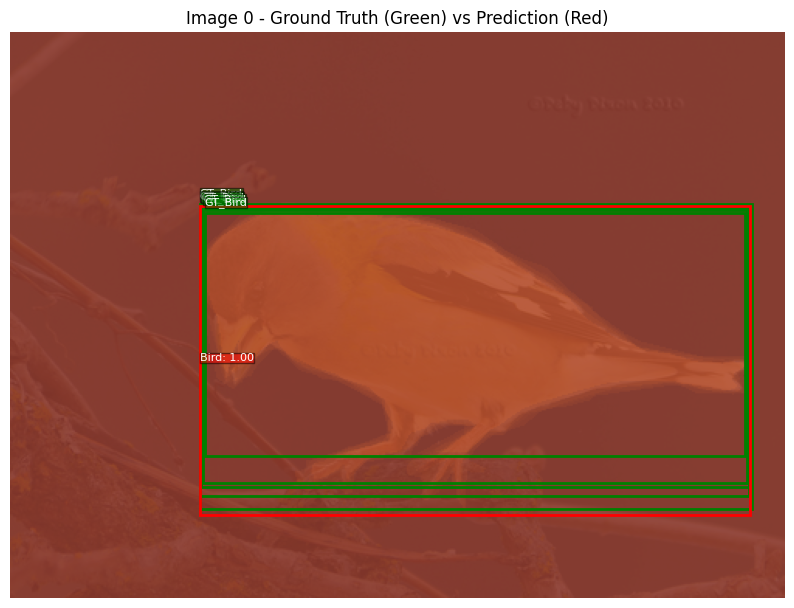

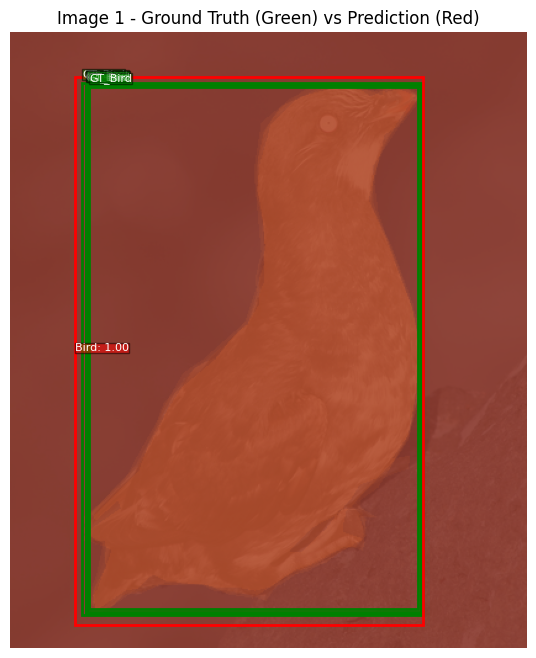

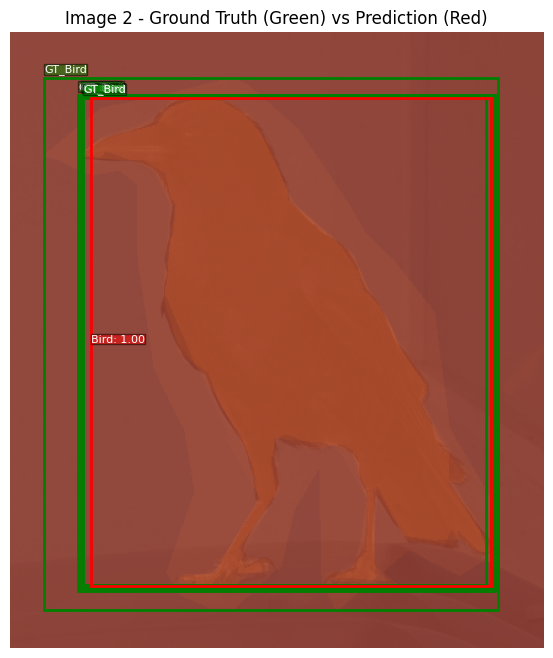

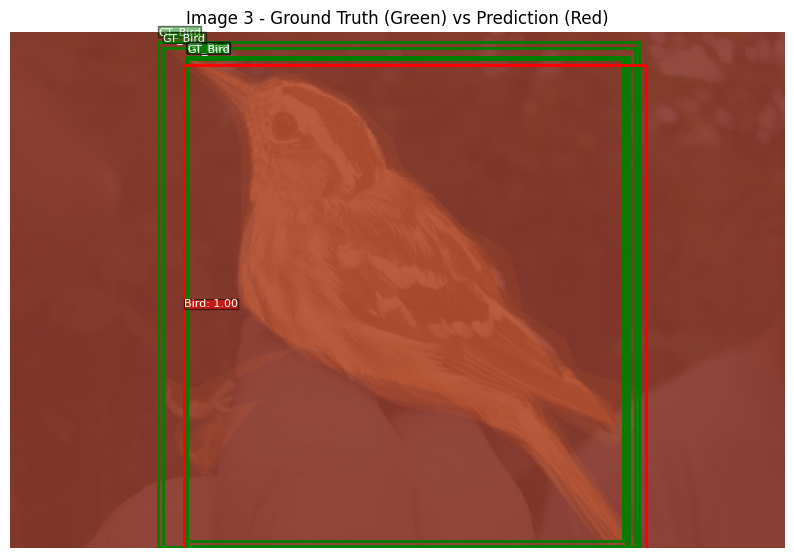

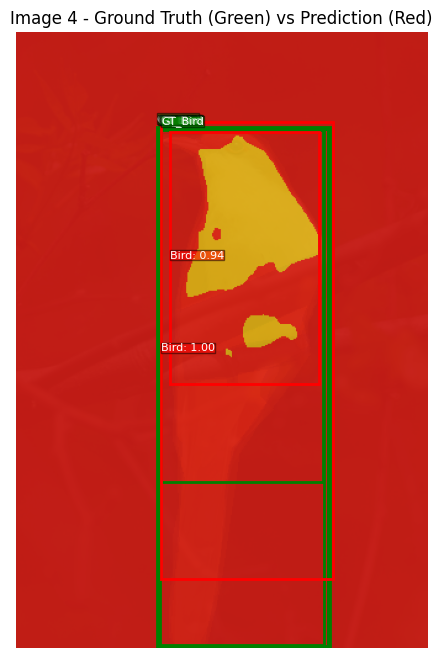

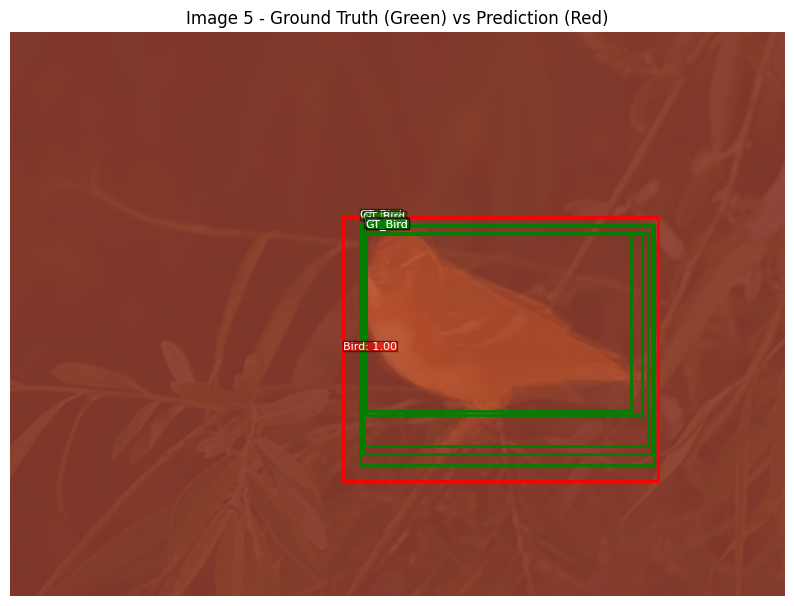

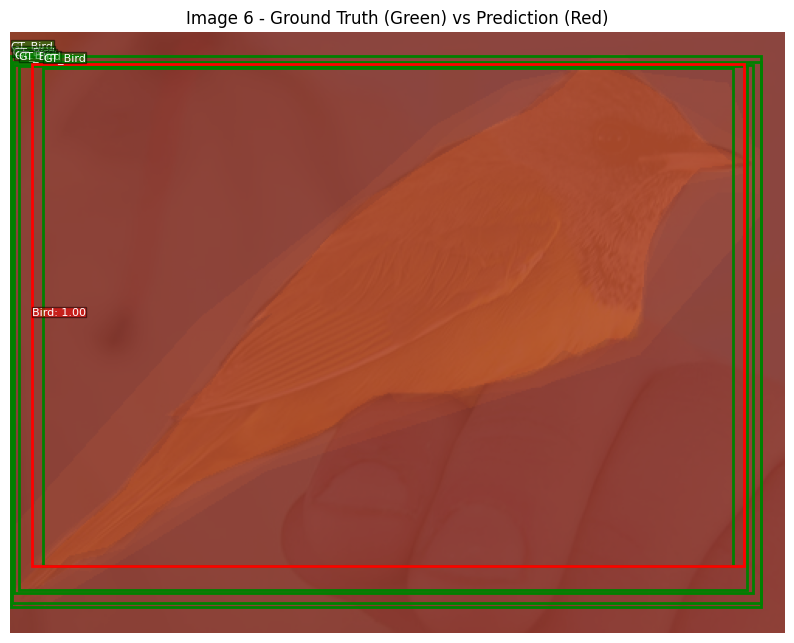

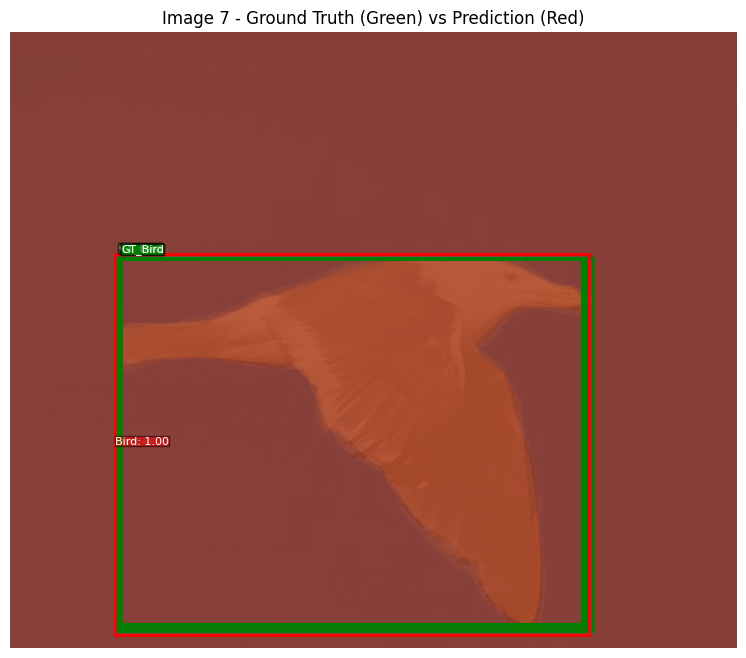

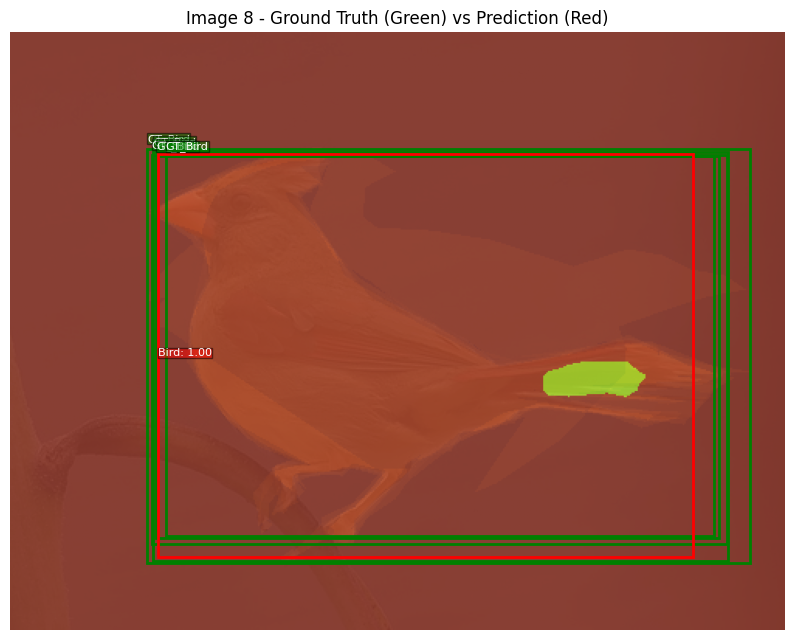

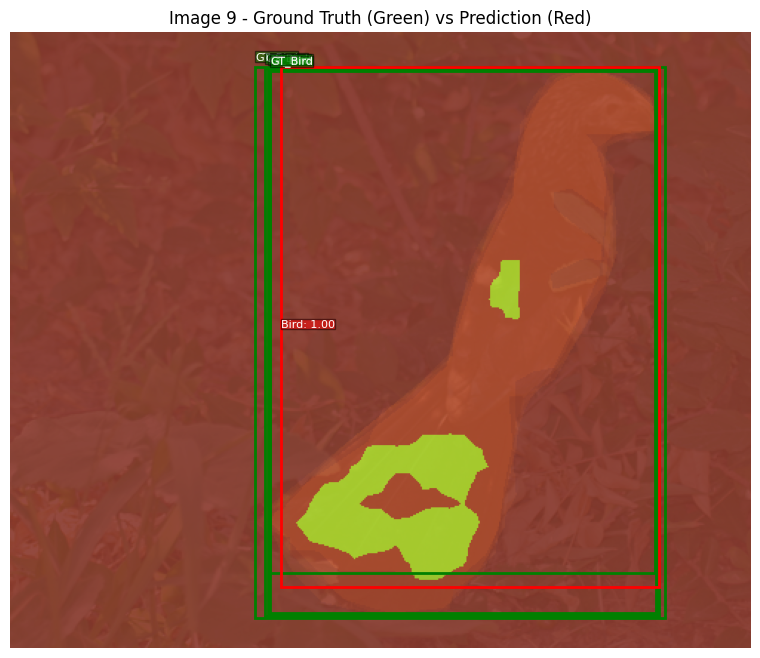

Evaluasi visual selesai. Untuk metrik mAP, perlu implementasi COCOEvaluator yang lebih lengkap.
Evaluasi model selesai.


In [ ]:
# ================================================================================================
# 5. MODEL EVALUATION AND TESTING
# ================================================================================================

def setup_evaluation_environment():
    """
    Setup model and data for evaluation
    
    Returns:
        tuple: (model, data_loader_val, device)
    """
    print("🔧 Setting up evaluation environment...")
    
    # Ensure device is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model architecture (same as training)
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=weights)
    
    # Customize for bird detection
    num_classes_birds = 2
    in_features_box = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features_box, num_classes_birds
    )
    
    in_features_mask = model.roi_heads.mask_predictor.mask_fcn_logits.in_channels
    hidden_layer = model.roi_heads.mask_predictor.mask_fcn_logits.out_channels
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes_birds
    )
    
    model.to(device)
    
    # Load trained weights
    model_load_path = "model/mask_rcnn_burung_final.pth"
    if os.path.exists(model_load_path):
        load_model_only(model_load_path, model, device)
        print(f"✅ Trained model loaded for evaluation")
    else:
        print(f"⚠️  Model file not found: {model_load_path}")
        print("   Evaluation will use untrained model")
    
    # Setup validation dataset
    ROOT_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/CUB_200_2011'
    SEGMENTATIONS_DIR = 'D:/Personal/AI/Computer Vision/Mask R-CNN/Caltech-UCSD Birds-200-2011/Fine-tuning/segmentations/segmentations'
    
    dataset_val = BirdMaskRCNNDataset(ROOT_DIR, SEGMENTATIONS_DIR, transforms=None)
    
    # Create validation split (same as training)
    torch.manual_seed(1)  # Same seed for consistent split
    indices = torch.randperm(len(dataset_val)).tolist()
    dataset_val_subset = torch.utils.data.Subset(dataset_val, indices[-50:])  # Last 50 for validation
    
    data_loader_val = DataLoader(
        dataset_val_subset,
        batch_size=1,  # Single images for detailed evaluation
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    print(f"📊 Evaluation setup complete:")
    print(f"   Device: {device}")
    print(f"   Validation samples: {len(dataset_val_subset)}")
    print(f"   Model loaded: {'Yes' if os.path.exists(model_load_path) else 'No'}")
    
    return model, data_loader_val, device

def evaluate_model_visual(model, data_loader, device, max_images=10, score_threshold=0.7):
    """
    Perform visual evaluation of the model
    
    Args:
        model (torch.nn.Module): Trained model
        data_loader (DataLoader): Validation data loader
        device (torch.device): Computation device
        max_images (int): Maximum number of images to visualize
        score_threshold (float): Confidence threshold for predictions
    """
    print(f"🔍 Starting visual evaluation...")
    print(f"   Score threshold: {score_threshold}")
    print(f"   Max images to display: {max_images}")
    print("=" * 60)
    
    model.eval()  # Set to evaluation mode
    cpu_device = torch.device("cpu")
    
    evaluation_stats = {
        'total_images': 0,
        'images_with_predictions': 0,
        'total_predictions': 0,
        'total_ground_truth': 0
    }
    
    with torch.no_grad():
        for image_idx, (images, targets) in enumerate(tqdm(data_loader, desc="Evaluating")):
            if image_idx >= max_images:
                break
                
            evaluation_stats['total_images'] += 1
            
            # Move images to device for inference
            images_gpu = list(img.to(device) for img in images)
            
            # Get predictions
            outputs = model(images_gpu)
            
            # Move outputs to CPU for processing
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
            
            # Process predictions and ground truth
            img_display = F.to_pil_image(images[0].cpu())
            
            # Create visualization
            plt.figure(figsize=(15, 10))
            plt.imshow(img_display)
            ax = plt.gca()
            
            # Draw ground truth (green)
            gt_boxes = targets[0]['boxes'].cpu().numpy()
            gt_labels = targets[0]['labels'].cpu().numpy()
            gt_masks = targets[0]['masks'].cpu().numpy()
            
            evaluation_stats['total_ground_truth'] += len(gt_boxes)
            
            for j in range(gt_boxes.shape[0]):
                box = gt_boxes[j]
                
                # Draw ground truth mask
                if j < len(gt_masks):
                    mask_img = Image.fromarray(gt_masks[j] * 255)
                    ax.imshow(mask_img, alpha=0.3, cmap='Greens')
                
                # Draw ground truth bounding box
                rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   fill=False, edgecolor='green', linewidth=3)
                ax.add_patch(rect)
                ax.text(box[0], box[1]-5, 'GT: Bird', 
                       bbox={'facecolor': 'green', 'alpha': 0.7, 'pad': 2}, 
                       color='white', fontsize=10, weight='bold')
            
            # Draw predictions (red)
            pred_boxes = outputs[0]['boxes'].cpu().numpy()
            pred_labels = outputs[0]['labels'].cpu().numpy()
            pred_scores = outputs[0]['scores'].cpu().numpy()
            pred_masks = outputs[0]['masks'].cpu().numpy()
            
            # Filter predictions by score threshold
            keep_indices = np.where(pred_scores > score_threshold)[0]
            evaluation_stats['total_predictions'] += len(keep_indices)
            
            if len(keep_indices) > 0:
                evaluation_stats['images_with_predictions'] += 1
            
            for j in keep_indices:
                box = pred_boxes[j]
                score = pred_scores[j]
                
                # Draw prediction mask
                mask_prob = pred_masks[j, 0]
                mask_binary = (mask_prob > 0.5).astype(np.uint8) * 255
                mask_img = Image.fromarray(mask_binary)
                ax.imshow(mask_img, alpha=0.4, cmap='Reds')
                
                # Draw prediction bounding box
                rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                   fill=False, edgecolor='red', linewidth=3)
                ax.add_patch(rect)
                ax.text(box[2], box[1], f'Pred: {score:.2f}', 
                       bbox={'facecolor': 'red', 'alpha': 0.7, 'pad': 2}, 
                       color='white', fontsize=10, weight='bold')
            
            # Add title with statistics
            gt_count = len(gt_boxes)
            pred_count = len(keep_indices)
            title = f"Image {image_idx + 1} | GT: {gt_count} birds | Predictions: {pred_count} birds (>{score_threshold:.1f})"
            plt.title(title, fontsize=14, weight='bold', pad=20)
            
            # Add legend
            from matplotlib.patches import Patch
            legend_elements = [
                Patch(facecolor='green', alpha=0.7, label='Ground Truth'),
                Patch(facecolor='red', alpha=0.7, label='Predictions')
            ]
            plt.legend(handles=legend_elements, loc='upper right')
            
            plt.axis('off')
            plt.tight_layout()
            plt.show()
    
    # Print evaluation summary
    print(f"\n📊 Evaluation Summary:")
    print(f"   Total images evaluated: {evaluation_stats['total_images']}")
    print(f"   Images with predictions: {evaluation_stats['images_with_predictions']}")
    print(f"   Total ground truth objects: {evaluation_stats['total_ground_truth']}")
    print(f"   Total predictions (>{score_threshold}): {evaluation_stats['total_predictions']}")
    
    if evaluation_stats['total_images'] > 0:
        avg_gt_per_image = evaluation_stats['total_ground_truth'] / evaluation_stats['total_images']
        avg_pred_per_image = evaluation_stats['total_predictions'] / evaluation_stats['total_images']
        detection_rate = evaluation_stats['images_with_predictions'] / evaluation_stats['total_images'] * 100
        
        print(f"   Average GT per image: {avg_gt_per_image:.2f}")
        print(f"   Average predictions per image: {avg_pred_per_image:.2f}")
        print(f"   Detection rate: {detection_rate:.1f}%")

# Setup and run evaluation
print("🔧 Setting up evaluation environment...")
model, data_loader_val, device = setup_evaluation_environment()

print("\n🔍 Running visual evaluation...")
evaluate_model_visual(model, data_loader_val, device, max_images=10, score_threshold=0.7)


Melakukan prediksi pada gambar uji...

Jumlah burung terdeteksi: 0 (dengan score threshold > 0.80)


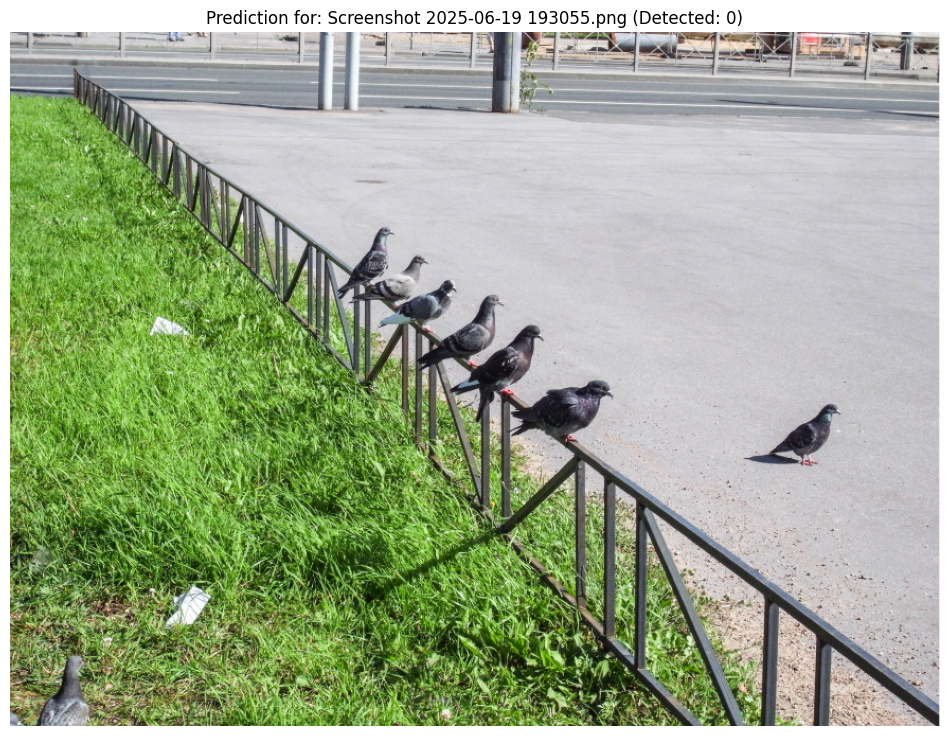

In [ ]:
# ================================================================================================
# 6. SINGLE IMAGE PREDICTION AND TESTING
# ================================================================================================

def predict_single_image(image_path, model, device, score_threshold=0.7, display_results=True):
    """
    Perform prediction on a single image
    
    Args:
        image_path (str): Path to the image file
        model (torch.nn.Module): Trained model
        device (torch.device): Computation device
        score_threshold (float): Confidence threshold for predictions
        display_results (bool): Whether to display visualization
        
    Returns:
        dict: Prediction results with statistics
    """
    print(f"🔍 Analyzing image: {os.path.basename(image_path)}")
    
    # Validate image path
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None
    
    try:
        # Load and preprocess image
        img_pil = Image.open(image_path).convert("RGB")
        img_tensor = F.to_tensor(img_pil)  # Convert to tensor (0-1 range)
        
        # Move to device and add batch dimension
        img_tensor = img_tensor.to(device)
        input_batch = [img_tensor]
        
        # Set model to evaluation mode
        model.eval()
        
        # Perform inference
        print("   🧠 Running inference...")
        start_time = time.time()
        
        with torch.no_grad():
            predictions = model(input_batch)
        
        inference_time = time.time() - start_time
        print(f"   ⏱️  Inference time: {inference_time:.3f}s")
        
        # Extract predictions
        output = predictions[0]
        
        # Move to CPU and convert to numpy
        pred_results = {
            'boxes': output['boxes'].to("cpu").numpy(),
            'labels': output['labels'].to("cpu").numpy(),
            'scores': output['scores'].to("cpu").numpy(),
            'masks': output['masks'].to("cpu").numpy()
        }
        
        # Filter by score threshold
        keep_indices = np.where(pred_results['scores'] > score_threshold)[0]
        
        filtered_results = {
            'boxes': pred_results['boxes'][keep_indices],
            'labels': pred_results['labels'][keep_indices],
            'scores': pred_results['scores'][keep_indices],
            'masks': pred_results['masks'][keep_indices]
        }
        
        num_detections = len(keep_indices)
        print(f"   🎯 Detections found: {num_detections} (threshold > {score_threshold})")
        
        # Display detailed prediction info
        if num_detections > 0:
            print(f"   📊 Prediction Details:")
            for i, score in enumerate(filtered_results['scores']):
                box = filtered_results['boxes'][i]
                print(f"      Bird {i+1}: Confidence {score:.3f}, "
                      f"BBox [{box[0]:.0f}, {box[1]:.0f}, {box[2]:.0f}, {box[3]:.0f}]")
        
        # Visualization of the image file
        if display_results:
            plt.figure(figsize=(10, 8))
            plt.imshow(img_pil)
            plt.axis('off')
            plt.title(f"The image of {os.path.basename(image_path)}")
            plt.show()
        
        # Visualization of the predictions
        if display_results:
            visualize_predictions(img_pil, filtered_results, image_path, score_threshold)
        
        # Return results summary
        return {
            'image_path': image_path,
            'num_detections': num_detections,
            'inference_time': inference_time,
            'predictions': filtered_results,
            'threshold': score_threshold
        }
        
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        return None

def visualize_predictions(img_pil, predictions, image_path, score_threshold):
    """
    Visualize predictions on the image
    
    Args:
        img_pil (PIL.Image): Original image
        predictions (dict): Filtered prediction results
        image_path (str): Path to original image
        score_threshold (float): Threshold used for filtering
    """
    plt.figure(figsize=(14, 10))
    plt.imshow(img_pil)
    ax = plt.gca()
    
    # Draw each prediction
    for i in range(len(predictions['boxes'])):
        box = predictions['boxes'][i]
        score = predictions['scores'][i]
        mask_prob = predictions['masks'][i, 0]  # First channel of mask
        
        # Create binary mask
        mask_binary = (mask_prob > 0.5).astype(np.uint8) * 255
        mask_img = Image.fromarray(mask_binary)
        
        # Overlay mask with transparency
        ax.imshow(mask_img, alpha=0.5, cmap='plasma')
        
        # Draw bounding box
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                           fill=False, edgecolor='red', linewidth=3)
        ax.add_patch(rect)
        
        # Add confidence label
        label_text = f"Bird {i+1}: {score:.2f}"
        ax.text(box[0], box[1]-10, label_text, 
               bbox={'facecolor': 'red', 'alpha': 0.8, 'pad': 3}, 
               color='white', fontsize=12, weight='bold')
    
    # Add title and information
    num_detections = len(predictions['boxes'])
    title = f"Prediction Results: {os.path.basename(image_path)}\n"
    title += f"Detected: {num_detections} birds (confidence > {score_threshold})"
    
    plt.title(title, fontsize=16, weight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def test_multiple_images(image_paths, model, device, score_threshold=0.7):
    """
    Test the model on multiple images
    
    Args:
        image_paths (list): List of image paths to test
        model (torch.nn.Module): Trained model
        device (torch.device): Computation device
        score_threshold (float): Confidence threshold
        
    Returns:
        list: Results for each image
    """
    print(f"🧪 Testing model on {len(image_paths)} images...")
    print("=" * 60)
    
    results = []
    total_detections = 0
    total_time = 0
    
    for i, image_path in enumerate(image_paths, 1):
        print(f"\\n📸 Image {i}/{len(image_paths)}: {os.path.basename(image_path)}")
        
        result = predict_single_image(image_path, model, device, score_threshold, display_results=True)
        
        if result:
            results.append(result)
            total_detections += result['num_detections']
            total_time += result['inference_time']
        else:
            print(f"   ⚠️  Failed to process image")
    
    # Print summary
    print(f"\\n📊 Testing Summary:")
    print(f"   Images processed: {len(results)}/{len(image_paths)}")
    print(f"   Total detections: {total_detections}")
    print(f"   Average detections per image: {total_detections/len(results) if results else 0:.2f}")
    print(f"   Average inference time: {total_time/len(results) if results else 0:.3f}s")
    
    return results

# Test on sample images
print("🧪 Testing trained model on sample images...")

# Define test images
test_images = [
    'test/img_6942.jpeg',
    'test/Screenshot 2025-06-19 191926.png',
    'test/Screenshot 2025-06-19 192016.png',
    'test/Screenshot 2025-06-19 192157.png',
    'test/Screenshot 2025-06-19 192812.png',
    # Add more test images if available
]

# Validate test images exist
valid_test_images = []
for img_path in test_images:
    if os.path.exists(img_path):
        valid_test_images.append(img_path)
        print(f"✅ Found test image: {os.path.basename(img_path)}")
    else:
        print(f"⚠️  Test image not found: {img_path}")

if valid_test_images:
    # Test the model
    test_results = test_multiple_images(valid_test_images, model, device, score_threshold=0.8)
else:
    print("❌ No valid test images found. Please add test images to the 'test/' directory.")


In [ ]:
# ================================================================================================
# 8. REAL-TIME DETECTION WITH WEBCAM
# ================================================================================================

import cv2
import time

def initialize_webcam(camera_index=0):
    """
    Initialize webcam for real-time detection
    
    Args:
        camera_index (int): Camera index (0 for built-in webcam)
        
    Returns:
        cv2.VideoCapture: Camera capture object
    """
    print(f"📹 Initializing webcam (index: {camera_index})...")
    
    cap = cv2.VideoCapture(camera_index)
    
    if not cap.isOpened():
        print(f"❌ Error: Cannot open webcam at index {camera_index}")
        print("Troubleshooting tips:")
        print("  • Check if camera is being used by another application")
        print("  • Try different camera indices (1, 2, etc.)")
        print("  • Restart the application")
        return None
    
    # Get camera properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps_cap = cap.get(cv2.CAP_PROP_FPS)
    
    print(f"✅ Webcam initialized successfully:")
    print(f"   Resolution: {width}x{height}")
    print(f"   Camera FPS: {fps_cap}")
    
    return cap

def run_realtime_detection(model, device, camera_index=0, score_threshold=0.7, 
                          max_duration=None, display_fps=True):
    """
    Run real-time bird detection using webcam
    
    Args:
        model (torch.nn.Module): Trained model
        device (torch.device): Computation device
        camera_index (int): Camera index
        score_threshold (float): Confidence threshold
        max_duration (int, optional): Maximum duration in seconds
        display_fps (bool): Whether to display FPS counter
    """
    print(f"🎬 Starting real-time bird detection...")
    print(f"   Score threshold: {score_threshold}")
    print(f"   Device: {device}")
    if max_duration:
        print(f"   Duration limit: {max_duration}s")
    print(f"   Controls: Press 'q' to quit")
    print("=" * 60)
    
    # Initialize webcam
    cap = initialize_webcam(camera_index)
    if cap is None:
        return
    
    # Set model to evaluation mode
    model.eval()
    
    # Get colormap for masks
    colors = plt.get_cmap('tab20c')
    
    # Performance tracking
    frame_count = 0
    total_inference_time = 0
    start_time = time.time()
    prev_frame_time = 0
    
    # Detection statistics
    detection_stats = {
        'frames_with_detections': 0,
        'total_detections': 0,
        'max_detections_per_frame': 0
    }
    
    try:
        print("🔴 Detection started - Press 'q' to stop")
        
        while True:
            # Check duration limit
            if max_duration and (time.time() - start_time) > max_duration:
                print(f"⏰ Duration limit reached ({max_duration}s)")
                break
            
            # Capture frame
            ret, frame = cap.read()
            if not ret:
                print("⚠️  Failed to capture frame")
                break
            
            frame_count += 1
            
            # Preprocess frame
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(frame_rgb)
            img_tensor = F.to_tensor(img_pil).to(device)
            input_batch = [img_tensor]
            
            # Perform inference
            inference_start = time.time()
            with torch.no_grad():
                predictions = model(input_batch)
            inference_time = time.time() - inference_start
            total_inference_time += inference_time
            
            # Process predictions
            output = predictions[0]
            pred_boxes = output['boxes'].to("cpu").numpy()
            pred_scores = output['scores'].to("cpu").numpy()
            pred_masks = output['masks'].to("cpu").numpy()
            
            # Filter by threshold
            keep_indices = np.where(pred_scores > score_threshold)[0]
            num_detections = len(keep_indices)
            
            # Update statistics
            if num_detections > 0:
                detection_stats['frames_with_detections'] += 1
                detection_stats['total_detections'] += num_detections
                detection_stats['max_detections_per_frame'] = max(
                    detection_stats['max_detections_per_frame'], num_detections
                )
            
            # Draw predictions on frame
            for i in keep_indices:
                box = pred_boxes[i].astype(int)
                score = pred_scores[i]
                mask_prob = pred_masks[i, 0]
                
                # Create and apply mask
                mask_binary = (mask_prob > 0.5).astype(np.uint8) * 255
                mask_resized = cv2.resize(mask_binary, (frame.shape[1], frame.shape[0]), 
                                        interpolation=cv2.INTER_NEAREST)
                
                # Apply colored mask
                mask_color = colors(0)[:3]
                mask_color = (np.array(mask_color) * 255).astype(np.uint8)
                colored_mask = np.zeros_like(frame_rgb)
                colored_mask[mask_resized > 0] = mask_color
                
                alpha = 0.5
                frame_rgb = cv2.addWeighted(frame_rgb, 1, colored_mask, alpha, 0)
                
                # Draw bounding box
                cv2.rectangle(frame_rgb, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)
                
                # Add label
                label_text = f"Bird: {score:.2f}"
                cv2.putText(frame_rgb, label_text, (box[0], box[1] - 10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
            
            # Add information overlay
            cv2.putText(frame_rgb, f"Detected: {num_detections}", (20, 40),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            # Calculate and display FPS
            if display_fps:
                current_time = time.time()
                if prev_frame_time != 0:
                    fps = 1 / (current_time - prev_frame_time)
                    fps_text = f"FPS: {int(fps)}"
                    cv2.putText(frame_rgb, fps_text, (frame.shape[1] - 120, 40),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
                prev_frame_time = current_time
            
            # Display frame
            display_frame = cv2.cvtColor(frame_rgb, cv2.COLOR_RGB2BGR)
            cv2.imshow('Mask R-CNN Bird Detection', display_frame)
            
            # Print periodic updates
            if frame_count % 30 == 0:  # Every 30 frames
                avg_inference = total_inference_time / frame_count
                detection_rate = detection_stats['frames_with_detections'] / frame_count * 100
                print(f"Frame {frame_count}: {num_detections} birds | "
                      f"Avg inference: {avg_inference:.3f}s | "
                      f"Detection rate: {detection_rate:.1f}%")
            
            # Check for quit command
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    except KeyboardInterrupt:
        print("\\n⚠️  Interrupted by user")
    except Exception as e:
        print(f"\\n❌ Error during detection: {e}")
    finally:
        # Cleanup and statistics
        cap.release()
        cv2.destroyAllWindows()
        
        # Print final statistics
        total_time = time.time() - start_time
        avg_fps = frame_count / total_time if total_time > 0 else 0
        avg_inference = total_inference_time / frame_count if frame_count > 0 else 0
        detection_rate = detection_stats['frames_with_detections'] / frame_count * 100 if frame_count > 0 else 0
        
        print(f"\\n📊 Detection Session Summary:")
        print(f"   Total duration: {total_time:.1f}s")
        print(f"   Frames processed: {frame_count}")
        print(f"   Average FPS: {avg_fps:.1f}")
        print(f"   Average inference time: {avg_inference:.3f}s")
        print(f"   Frames with detections: {detection_stats['frames_with_detections']}")
        print(f"   Detection rate: {detection_rate:.1f}%")
        print(f"   Total birds detected: {detection_stats['total_detections']}")
        print(f"   Max birds in single frame: {detection_stats['max_detections_per_frame']}")
        print("✅ Real-time detection completed")

# Configuration for real-time detection
REALTIME_CONFIG = {
    'camera_index': 0,
    'score_threshold': 0.7,
    'max_duration': None,  # No time limit (set to seconds if needed)
    'display_fps': True
}

print("🎬 Real-time Detection Configuration:")
for key, value in REALTIME_CONFIG.items():
    print(f"   {key}: {value}")

print("\\n" + "="*60)
print("🎯 Ready to start real-time detection!")
print("📝 Instructions:")
print("   1. Make sure your webcam is connected and not in use")
print("   2. Run the cell below to start detection")
print("   3. Position birds in front of the camera")
print("   4. Press 'q' to stop detection")
print("="*60)

# Uncomment the line below to start real-time detection
# run_realtime_detection(model, device, **REALTIME_CONFIG)

Mulai streaming dari webcam. Tekan 'q' untuk keluar.


In [ ]:
# ================================================================================================
# 9. PROJECT SUMMARY AND NEXT STEPS
# ================================================================================================

def display_project_summary():
    """
    Display comprehensive project summary and available functionalities
    """
    print("🎯 MASK R-CNN BIRD DETECTION PROJECT SUMMARY")
    print("=" * 80)
    
    print("\n📋 PROJECT OVERVIEW:")
    print("   • Fine-tuned Mask R-CNN (ResNet-50 FPN) for bird detection")
    print("   • Dataset: Caltech-UCSD Birds-200-2011 (CUB-200-2011)")
    print("   • Capabilities: Object detection + Instance segmentation")
    print("   • Real-time detection: Webcam integration with OpenCV")
    
    print("\n🏗️  MODEL ARCHITECTURE:")
    print("   • Backbone: ResNet-50 with Feature Pyramid Network (FPN)")
    print("   • Pre-trained: COCO dataset weights")
    print("   • Custom heads: 2 classes (background + bird)")
    print("   • Output: Bounding boxes + segmentation masks")
    
    print("\n📊 TRAINING CONFIGURATION:")
    print("   • Optimizer: SGD (lr=0.005, momentum=0.9, weight_decay=0.0005)")
    print("   • Scheduler: StepLR (step_size=3, gamma=0.1)")
    print("   • Epochs: 10 (configurable)")
    print("   • Batch size: 2 (GPU memory dependent)")
    
    print("\n🗂️  AVAILABLE FUNCTIONS:")
    print("   📥 Data Loading:")
    print("      • BirdMaskRCNNDataset: Custom dataset class for CUB-200-2011")
    print("      • parse_bounding_boxes(): Parse bounding box annotations")
    print("      • parse_image_names(): Parse image filename mappings")
    
    print("\n   🚀 Training:")
    print("      • train_model(): Complete training pipeline with checkpointing")
    print("      • setup_training_components(): Configure optimizer and scheduler")
    print("      • save_checkpoint(): Save training progress")
    
    print("\n   💾 Checkpoint Management:")
    print("      • load_checkpoint(): Load complete checkpoint with optimizer/scheduler")
    print("      • load_model_only(): Load only model weights")
    print("      • list_available_checkpoints(): View saved checkpoints")
    print("      • get_checkpoint_info(): Get detailed checkpoint information")
    
    print("\n   🔍 Evaluation:")
    print("      • evaluate_model_visual(): Visual evaluation with GT comparison")
    print("      • predict_single_image(): Test on individual images")
    print("      • test_multiple_images(): Batch testing on multiple images")
    
    print("\n   🎬 Real-time Detection:")
    print("      • run_realtime_detection(): Webcam-based real-time detection")
    print("      • initialize_webcam(): Setup camera capture")
    
    print("\n📁 FILE STRUCTURE:")
    print("   • Mask RCNN.ipynb: Main training and evaluation notebook")
    print("   • realtime-detection.py: Standalone real-time detection script")
    print("   • model_checkpoints/: Saved model weights and checkpoints")
    print("   • CUB_200_2011/: Dataset directory")
    print("   • segmentations/: Custom segmentation masks")
    print("   • test/: Test images directory")
    
    print("\n🎯 USAGE EXAMPLES:")
    print("   # Load trained model")
    print("   load_model_only('model_checkpoints/mask_rcnn_burung_final.pth', model, device)")
    print()
    print("   # Test on single image")
    print("   result = predict_single_image('test/bird_image.jpg', model, device)")
    print()
    print("   # Start real-time detection")
    print("   run_realtime_detection(model, device, score_threshold=0.7)")
    print()
    print("   # Resume training from checkpoint")
    print("   load_checkpoint('model_checkpoints/mask_rcnn_burung_epoch_06.pth', model, optimizer, scheduler)")

def display_next_steps():
    """
    Display potential improvements and next steps
    """
    print("\n🔮 SUGGESTED IMPROVEMENTS & NEXT STEPS:")
    print("=" * 60)
    
    print("\n🧠 Model Improvements:")
    print("   • Experiment with larger backbones (ResNet-101, ResNeXt)")
    print("   • Implement data augmentation (horizontal flip, rotation, color jitter)")
    print("   • Multi-scale training and testing")
    print("   • Hard negative mining for better background detection")
    
    print("\n📊 Dataset Enhancements:")
    print("   • Expand to multi-class bird species classification")
    print("   • Add more diverse bird images (different poses, lighting)")
    print("   • Improve segmentation mask quality")
    print("   • Include challenging scenarios (multiple birds, occlusion)")
    
    print("\n⚡ Performance Optimization:")
    print("   • Model quantization for faster inference")
    print("   • TensorRT optimization for GPU deployment")
    print("   • ONNX export for cross-platform compatibility")
    print("   • Mobile deployment with PyTorch Mobile")
    
    print("\n🌐 Deployment Options:")
    print("   • Web application with Flask/FastAPI")
    print("   • REST API for cloud deployment")
    print("   • Mobile app integration")
    print("   • Edge device deployment (Raspberry Pi, Jetson)")
    
    print("\n📈 Advanced Features:")
    print("   • Bird tracking across video frames")
    print("   • Behavior analysis and classification")
    print("   • Integration with bird identification databases")
    print("   • Automated counting and monitoring systems")

def display_troubleshooting_guide():
    """
    Display common issues and solutions
    """
    print("\n🔧 TROUBLESHOOTING GUIDE:")
    print("=" * 50)
    
    print("\n❌ Common Issues & Solutions:")
    
    print("\n1. CUDA Out of Memory:")
    print("   • Reduce batch size in DataLoader")
    print("   • Use model.to('cpu') for CPU training")
    print("   • Clear GPU cache with torch.cuda.empty_cache()")
    
    print("\n2. Webcam Not Opening:")
    print("   • Close other applications using the camera")
    print("   • Try different camera indices (0, 1, 2)")
    print("   • Check camera drivers and permissions")
    
    print("\n3. Model Loading Errors:")
    print("   • Verify model file path exists")
    print("   • Ensure model architecture matches training")
    print("   • Check device compatibility (CPU/GPU)")
    
    print("\n4. Poor Detection Performance:")
    print("   • Adjust score_threshold (try 0.5-0.8)")
    print("   • Ensure model is properly trained")
    print("   • Check input image quality and lighting")
    
    print("\n5. Slow Training:")
    print("   • Use GPU if available")
    print("   • Reduce number of workers in DataLoader")
    print("   • Consider smaller model or batch size")

# Display complete project information
display_project_summary()
display_next_steps()
display_troubleshooting_guide()

print("\n" + "="*80)
print("🎉 CONGRATULATIONS!")
print("You have successfully completed the Mask R-CNN Bird Detection project!")
print("The model is trained and ready for:")
print("   • Single image detection")
print("   • Real-time webcam detection") 
print("   • Further fine-tuning and experimentation")
print("="*80)